In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

import os
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Force TF to only allocate memory as needed on the GPU, otherwise TF attempts to allocate all the memory incase it needs it.
TF using all the memory leads to the "Failed to get convolution algorithm. This is probably because cuDNN failed to initialize," error.
Note that if RTX Voice (or other GPU memory heavy application) isn't running then this isn't needed.

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7168)])
    except RuntimeError as e:
        print(e)

In [32]:
SAVED_MODEL_PATH = "S:/Projects/AircraftClassifier/checkpoints/20-06-2020-22-42-00/cp-0100.ckpt"

In [40]:
model = tf.keras.models.load_model(SAVED_MODEL_PATH)

# Try retraining the model including some of the transfered layers

In [72]:
model.trainable = True

In [73]:
# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False

In [74]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  11529     
Total params: 2,269,513
Trainable params: 0
Non-trainable params: 2,269,513
_________________________________________________________________


# Make some test predictions

In [52]:
TEST_DIR = "reduced_training_data/test"
TEST_CLASSES = ["707-320", "737-800", "777-200", "a330-200", "bae 146-300", "c-130", "eurofighter typhoon", "md-80", "spitfire"]

# Image size in pixels.
IMG_HEIGHT = 224
IMG_WIDTH = 244


In [53]:
def plot_prediction(ax, prediction, actual, title):
    patches, texts, autotexts = ax.pie(prediction, labels=None, explode=[0.1] * len(prediction), autopct='%1.1f%%', shadow=True)
    
    ax.set_title(title)
#     ax.axis('equal')
    ax.legend(patches, TEST_CLASSES, bbox_to_anchor=(1.75, 0.5), loc="center right")

In [54]:
# This function will plot images in the form of a grid with 1 row and 3 columns.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [55]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                              directory=TEST_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="rgb",
                                                              class_mode='categorical')

Found 24 images belonging to 9 classes.


In [56]:
predictions = model.predict(test_data_gen)
actual_classes = test_data_gen.classes

NameError: name 'CHECKPOINT_DIR' is not defined

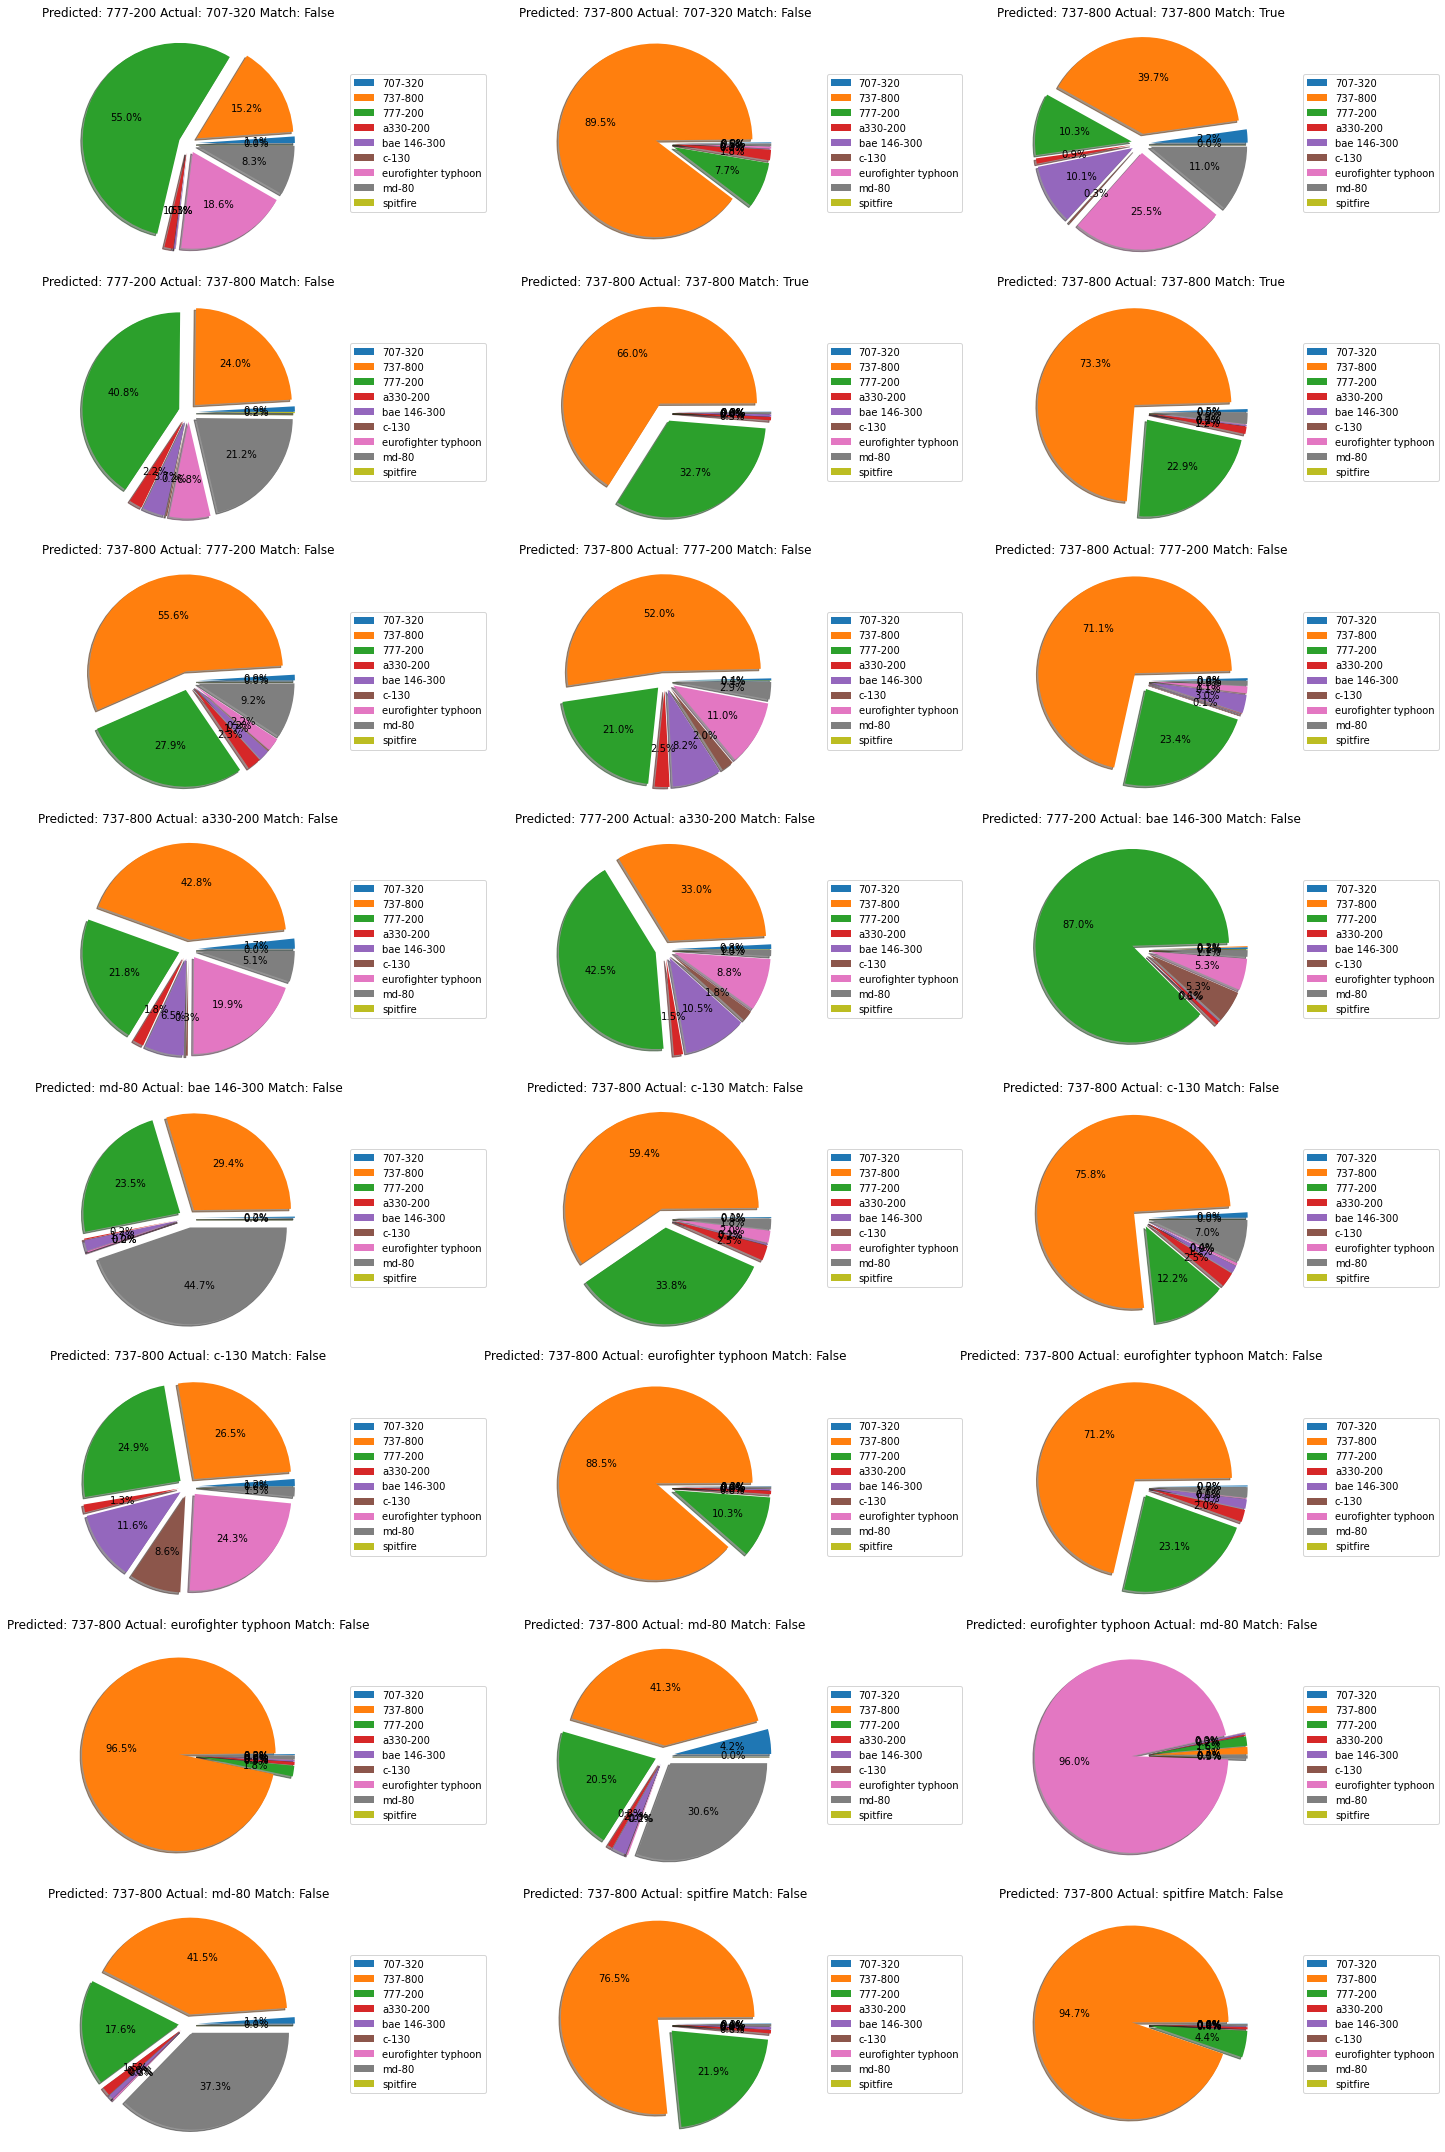

In [57]:
nrows = 3
ncol = 3

fig, ax = plt.subplots(math.ceil(len(predictions) / nrows), ncol, figsize=(20,30))

for index, predic in enumerate(predictions):
    predicted = np.argmax(predic)
    actual = actual_classes[index]
    title = "Predicted: {} Actual: {} Match: {}".format(TEST_CLASSES[predicted], TEST_CLASSES[actual], predicted==actual)
#     fig.figure(figsize=(6,24))
#     fig, ax = subplot(len(predictions), 1, index + 1)
    a = ax[int(index / nrows)][index % ncol]
    plot_prediction(a, predic, actual, title)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "test_results.pdf"), dpi=300, bbox_inches='tight')
plt.show()